## Testing the Model

Load the self trained model and create a pipeline that will:

- tokenize the input
 
- push to the model

- output the top 5 token that the model predict to fill each masked token

In [ ]:
import os

WORK_DIR = os.getenv('WORK')

DATA_FOLDER = os.path.join(WORK_DIR, "data")

CACHED_DATA_FOLDER = os.path.join(WORK_DIR, "cached_data")

# Salvamos o path do Cache par ao HuggingFace
os.environ['HF_HOME'] = CACHED_DATA_FOLDER
os.environ['TRITON_HIP_LLD_PATH'] = '/opt/rocm-6.4.1/lib/llvm/bin/ld.lld'


CACHED_DATA_FOLDER

'/work1/lgarcia/renneruan/cached_data'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from datasets import load_from_disk

vocabulary_size = 32_768
context_size =1024
tokenizer_name = "/work1/lgarcia/renneruan/data/tokenizers/custom/32_768"
model_name = f"Modern/classiccc-1024-unigram-32768-900ksteps"
output_dir = f"training_test/{model_name}"

tokenized_datasets_name = os.path.join(
    DATA_FOLDER,
    f"tokenized-for-training/custom/vocab_size:{vocabulary_size:_}/context_size:{context_size}",
)
# tokenized_datasets = load_from_disk(tokenized_datasets_name)

In [9]:
evaluation_dataset = tokenized_datasets["test"] #.select([i for i in range( int(1 * len(tokenized_datasets["test"])) )])

evaluation_dataset

NameError: name 'tokenized_datasets' is not defined

In [10]:
os.chdir(WORK_DIR)
print(os.getcwd())

/work1/lgarcia/renneruan


In [11]:
from transformers import (
    DataCollatorForLanguageModeling,
    AutoTokenizer,
)

tokenizer_name = "/work1/lgarcia/renneruan/tokenizers/custom/32_768"

tokenizer = AutoTokenizer.from_pretrained(
        tokenizer_name, local_files_only=True, cache_dir=CACHED_DATA_FOLDER
    )
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm = True,
    mlm_probability=0.3
) 

In [12]:
from transformers import pipeline, ModernBertForMaskedLM

last_checkpoint_path = f"/work1/lgarcia/renneruan/training_test/Modern/classiccc-1024-unigram-32768-900ksteps/checkpoint-900000"
model = ModernBertForMaskedLM.from_pretrained(last_checkpoint_path)

model.to('cuda')

/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Flash Attention 2 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in ModernBertForMaskedLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", dtype=torch.float16)`
Flash Attention 2 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in ModernBertModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `dtype` argument. Example: `model 

ModernBertForMaskedLM(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(32768, 768, padding_idx=0)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=10000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, b

In [ ]:
from transformers import Trainer, TrainingArguments
import numpy as np

model_name = 4.6
evaluation_args = TrainingArguments(
    output_dir=f'evaluating/{model_name}',

    do_train=False,
    eval_strategy = "steps", 
    eval_steps=1_000,
    # eval_accumulation_steps=1,

    per_device_eval_batch_size=32,           # batch size for evaluation

    logging_strategy="steps",
    logging_steps=1_000,
    logging_dir=f'evaluating/evaluation-logs/{model_name}',                # directory for storing logs
    report_to=["tensorboard"],

    save_strategy="steps",
    save_steps=1_000,                      # Save checkpoints every 100 steps
    save_total_limit=5,                  # Limit the total number of saved checkpoints

    fp16=True,    
)

evaluator = Trainer(
    model=model,   
    args=evaluation_args,
    train_dataset=[],
    eval_dataset=evaluation_dataset,         # Evaluation dataset
    data_collator=data_collator,
)


# Evaluate the model
eval_results = evaluator.evaluate()

# Print the results
print(eval_results)

/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/_inductor/compile_fx.py:309: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

In [13]:
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

test1 = "Eu não entendi [MASK], como proceder."

out = tokenizer(test1)

out

Device set to use cuda:0


{'input_ids': [2, 5, 11, 18, 32, 7471, 4, 5, 6, 36, 8060, 5, 12, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
tokenizer.convert_ids_to_tokens(out['input_ids'])

['[CLS]',
 '▁',
 'e',
 'u',
 '▁não',
 '▁entendi',
 '[MASK]',
 '▁',
 ',',
 '▁como',
 '▁proceder',
 '▁',
 '.',
 '[SEP]']

In [15]:
fill_mask(test1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[{'score': 0.42093050479888916,
  'token': 268,
  'token_str': 'nada',
  'sequence': 'eu não entendi nada , como proceder .'},
 {'score': 0.295015424489975,
  'token': 221,
  'token_str': 'direito',
  'sequence': 'eu não entendi direito , como proceder .'},
 {'score': 0.04745210334658623,
  'token': 88,
  'token_str': 'isso',
  'sequence': 'eu não entendi isso , como proceder .'},
 {'score': 0.03753681108355522,
  'token': 87,
  'token_str': 'bem',
  'sequence': 'eu não entendi bem , como proceder .'},
 {'score': 0.02749530039727688,
  'token': 73,
  'token_str': 'muito',
  'sequence': 'eu não entendi muito , como proceder .'}]

In [16]:
fill_mask("Atiraram o pau no [MASK]")

[{'score': 0.07447715103626251,
  'token': 2471,
  'token_str': 'chão',
  'sequence': 'atiraram o pau no chão'},
 {'score': 0.04844328761100769,
  'token': 638,
  'token_str': 'cara',
  'sequence': 'atiraram o pau no cara'},
 {'score': 0.04807326942682266,
  'token': 603,
  'token_str': 'carro',
  'sequence': 'atiraram o pau no carro'},
 {'score': 0.0307450108230114,
  'token': 2782,
  'token_str': 'lixo',
  'sequence': 'atiraram o pau no lixo'},
 {'score': 0.025770055130124092,
  'token': 189,
  'token_str': 'meu',
  'sequence': 'atiraram o pau no meu'}]

In [17]:
fill_mask("Essa frase tem [MASK] tokens, portanto ele vai gerar dois [MASK]")

[[{'score': 0.820105254650116,
   'token': 134,
   'token_str': 'dois',
   'sequence': '[CLS] essa frase tem dois tokens , portanto ele vai gerar dois[MASK][SEP]'},
  {'score': 0.016702167689800262,
   'token': 194,
   'token_str': 'três',
   'sequence': '[CLS] essa frase tem três tokens , portanto ele vai gerar dois[MASK][SEP]'},
  {'score': 0.015280155465006828,
   'token': 388,
   'token_str': 'vários',
   'sequence': '[CLS] essa frase tem vários tokens , portanto ele vai gerar dois[MASK][SEP]'},
  {'score': 0.014892123639583588,
   'token': 351,
   'token_str': 'quatro',
   'sequence': '[CLS] essa frase tem quatro tokens , portanto ele vai gerar dois[MASK][SEP]'},
  {'score': 0.00916376244276762,
   'token': 2753,
   'token_str': 'zero',
   'sequence': '[CLS] essa frase tem zero tokens , portanto ele vai gerar dois[MASK][SEP]'}],
 [{'score': 0.18531940877437592,
   'token': 6177,
   'token_str': 'blocos',
   'sequence': '[CLS] essa frase tem[MASK] tokens , portanto ele vai gerar do

## NER task

### Fine-tuning for for NER task

Download the curated dataset for portuguese NER task in the legal scope.

It already has the train, validation and test splits

In [18]:
from datasets import load_from_disk
from multiprocessing import cpu_count


lener_path = os.path.join(WORK_DIR, "data", "lener_br_local")

lenerNER = load_from_disk(lener_path)

print("Dataset loaded successfully from local disk!")
print(lenerNER)

Dataset loaded successfully from local disk!
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})


In [19]:
print( lenerNER["train"][0]["id"] ) # id of the document [0, 70)
    
print( lenerNER["train"][0]["tokens"] ) # words

print( lenerNER["train"][0]["ner_tags"] ) # tags for the words

0
['EMENTA', ':', 'APELAÇÃO', 'CÍVEL', '-', 'AÇÃO', 'DE', 'INDENIZAÇÃO', 'POR', 'DANOS', 'MORAIS', '-', 'PRELIMINAR', '-', 'ARGUIDA', 'PELO', 'MINISTÉRIO', 'PÚBLICO', 'EM', 'GRAU', 'RECURSAL', '-', 'NULIDADE', '-', 'AUSÊNCIA', 'DE', 'INTERVENÇÃO', 'DO', 'PARQUET', 'NA', 'INSTÂNCIA', 'A', 'QUO', '-', 'PRESENÇA', 'DE', 'INCAPAZ', '-', 'PREJUÍZO', 'EXISTENTE', '-', 'PRELIMINAR', 'ACOLHIDA', '-', 'NULIDADE', 'RECONHECIDA', '.']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Each ner_tag id corresponds to one of the following labels:

**BIO notation:**

B - means that is the beginning of a entity

I - means that it inside the entity (after a B tag)

O - means that this token a non-entity tokens

In [20]:
label_list = lenerNER["train"].features[f"ner_tags"].feature.names

label_list

['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']

Each word can be split into several tokens by our pre trained tokenizer, let's see an example:

word "PARQUET" was split into 2 tokens

In [21]:
exampleNER = lenerNER["train"][0]

example_tokenized_input = tokenizer(exampleNER["tokens"], is_split_into_words = True)

example_tokens = tokenizer.convert_ids_to_tokens(example_tokenized_input["input_ids"])

print(exampleNER["tokens"])
print(example_tokenized_input["input_ids"])
print(example_tokens)
print(exampleNER["ner_tags"])

['EMENTA', ':', 'APELAÇÃO', 'CÍVEL', '-', 'AÇÃO', 'DE', 'INDENIZAÇÃO', 'POR', 'DANOS', 'MORAIS', '-', 'PRELIMINAR', '-', 'ARGUIDA', 'PELO', 'MINISTÉRIO', 'PÚBLICO', 'EM', 'GRAU', 'RECURSAL', '-', 'NULIDADE', '-', 'AUSÊNCIA', 'DE', 'INTERVENÇÃO', 'DO', 'PARQUET', 'NA', 'INSTÂNCIA', 'A', 'QUO', '-', 'PRESENÇA', 'DE', 'INCAPAZ', '-', 'PREJUÍZO', 'EXISTENTE', '-', 'PRELIMINAR', 'ACOLHIDA', '-', 'NULIDADE', 'RECONHECIDA', '.']
[2, 16, 2091, 5, 50, 12806, 5, 7219, 5, 20, 5, 168, 9, 4873, 33, 1959, 3520, 5, 20, 8645, 5, 20, 6506, 18, 709, 53, 418, 206, 16, 1433, 17707, 5, 20, 10922, 5, 20, 1885, 9, 2463, 14, 1306, 41, 28, 5583, 5, 7, 5495, 8, 5, 20, 605, 9, 7982, 5, 20, 3566, 3580, 5, 20, 8645, 5, 7, 8247, 5, 20, 10922, 4134, 5, 12, 3]
['[CLS]', '▁em', 'enta', '▁', ':', '▁apelação', '▁', 'cível', '▁', '-', '▁', 'ação', '▁de', '▁indenização', '▁por', '▁danos', '▁morais', '▁', '-', '▁preliminar', '▁', '-', '▁arg', 'u', 'ida', '▁pelo', '▁ministério', '▁público', '▁em', '▁grau', '▁recursal', '▁',

**word_id:** the index of the word given prior to the tokenization!

check the example with word index 28

In [22]:
# if a word is split into 2 tokens, both will share the same word_id

example_word_ids = example_tokenized_input.word_ids()

for i, j in zip(example_word_ids, example_tokens):
    print(i, j)

None [CLS]
0 ▁em
0 enta
1 ▁
1 :
2 ▁apelação
3 ▁
3 cível
4 ▁
4 -
5 ▁
5 ação
6 ▁de
7 ▁indenização
8 ▁por
9 ▁danos
10 ▁morais
11 ▁
11 -
12 ▁preliminar
13 ▁
13 -
14 ▁arg
14 u
14 ida
15 ▁pelo
16 ▁ministério
17 ▁público
18 ▁em
19 ▁grau
20 ▁recursal
21 ▁
21 -
22 ▁nulidade
23 ▁
23 -
24 ▁ausência
25 ▁de
26 ▁intervenção
27 ▁do
28 ▁parque
28 t
29 ▁na
30 ▁instância
31 ▁
31 a
32 ▁qu
32 o
33 ▁
33 -
34 ▁presença
35 ▁de
36 ▁incapaz
37 ▁
37 -
38 ▁prejuízo
39 ▁existente
40 ▁
40 -
41 ▁preliminar
42 ▁
42 a
42 colhida
43 ▁
43 -
44 ▁nulidade
45 ▁reconhecida
46 ▁
46 .
None [SEP]


Tokenize the input and preprocess. 

We need also to align, because some words were split into several tokens

label of [CLS], [SEP] and for tokens that are suffixes (##) have label == -100 (meaning that it will be ignored for the ner tag prediction)

In [23]:
def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(examples["tokens"], 
                                 max_length=context_size,
                                 truncation=True, 
                                 is_split_into_words=True)

    labels = []

    for i, label in enumerate(examples[f"ner_tags"]):

        word_ids = tokenized_inputs.word_ids(batch_index=i)

        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:

            if word_idx is None: # [CLS], [SEP]
                label_ids.append(-100)

            elif word_idx != previous_word_idx: # new word
                label_ids.append(label[word_idx])

            else: # suffix of a previous token
                label_ids.append(-100)

            previous_word_idx = word_idx
            
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels

    return tokenized_inputs

tokenized_lenerNER = lenerNER.map(tokenize_and_align_labels,
                                  batched=True,
                                  num_proc=cpu_count(),
                                  )

In [24]:
tokenized_lenerNER

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1390
    })
})

In [25]:
from transformers import DataCollatorForTokenClassification

ner_collator = DataCollatorForTokenClassification(tokenizer=tokenizer,
                                                  padding=True,
                                                  )

load a evaluation metric that will be used to compute the total evaluation for a sequence (seq eval)

In [26]:
import evaluate

seqeval = evaluate.load("seqeval")

define the method to compute metrics (precision, recall, f1, accuracy)

In [27]:
import numpy as np

def compute_metrics_ner(p):

    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
}

Create dictionaries to convert id to label and vice-versa

In [28]:
id2label = {}
label2id = {}

for i, lab in enumerate(label_list):

    id2label[i] = lab
    label2id[lab] = i

print(id2label)
print(label2id)

{0: 'O', 1: 'B-ORGANIZACAO', 2: 'I-ORGANIZACAO', 3: 'B-PESSOA', 4: 'I-PESSOA', 5: 'B-TEMPO', 6: 'I-TEMPO', 7: 'B-LOCAL', 8: 'I-LOCAL', 9: 'B-LEGISLACAO', 10: 'I-LEGISLACAO', 11: 'B-JURISPRUDENCIA', 12: 'I-JURISPRUDENCIA'}
{'O': 0, 'B-ORGANIZACAO': 1, 'I-ORGANIZACAO': 2, 'B-PESSOA': 3, 'I-PESSOA': 4, 'B-TEMPO': 5, 'I-TEMPO': 6, 'B-LOCAL': 7, 'I-LOCAL': 8, 'B-LEGISLACAO': 9, 'I-LEGISLACAO': 10, 'B-JURISPRUDENCIA': 11, 'I-JURISPRUDENCIA': 12}


load the pre trained model of bert to fine tune it for NER task, attaching a Token Classification HEAD

In [29]:
from transformers import ModernBertForTokenClassification

ner_model = ModernBertForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=last_checkpoint_path,
    num_labels = len(label_list),
    id2label = id2label,
    label2id= label2id,
)

ner_model

Flash Attention 2 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in ModernBertForTokenClassification is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", dtype=torch.float16)`
Some weights of ModernBertForTokenClassification were not initialized from the model checkpoint at /work1/lgarcia/renneruan/training_test/Modern/classiccc-1024-unigram-32768-900ksteps/checkpoint-900000 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForTokenClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(32768, 768, padding_idx=0)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=10000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_feat

Train it in batches of size 16, while also computing the evaluation for the validation set

In [30]:
from transformers import TrainingArguments

ner_training_args = TrainingArguments(
    output_dir = f"trained/NER/{model_name}",
    overwrite_output_dir=True,
    
    num_train_epochs = 2,

    eval_strategy = "epoch",

    gradient_accumulation_steps = 1,
    eval_accumulation_steps = 1,

    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    
    learning_rate = 2e-5,
    weight_decay = 0.01,
    
    logging_first_step=True,
    save_strategy = "steps",
    save_steps=100,                      # Save checkpoints every 100 steps
    save_total_limit=5,

    fp16=True,
)

In [31]:
from transformers import Trainer

ner_trainer = Trainer(
    model = ner_model,
    train_dataset = tokenized_lenerNER["train"],
    eval_dataset = tokenized_lenerNER["validation"],
    data_collator = ner_collator,
    compute_metrics = compute_metrics_ner,
    args = ner_training_args
)

In [32]:
ner_trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,4.792700,0.064643,0.790918,0.871837,0.829409,0.983141
2,0.133500,0.054157,0.875468,0.900990,0.888046,0.986737


TrainOutput(global_step=980, training_loss=0.08177822512023303, metrics={'train_runtime': 92.0301, 'train_samples_per_second': 170.118, 'train_steps_per_second': 10.649, 'total_flos': 2009652842781480.0, 'train_loss': 0.08177822512023303, 'epoch': 2.0})

### Test NER Task

In [33]:
modern_ner_name = f"trained/NER/{model_name}"

In [34]:
import pandas as pd

def tag_sentence(text:str):

    # convert our text to a  tokenized sequence
    inputs = tokenizer(text, truncation=True, return_tensors="pt", return_token_type_ids=False).to("cuda:0")

    # get outputs
    outputs = ner_model(**inputs)

    # convert to probabilities with softmax
    probs = outputs[0][0].softmax(1)

    # get the tags with the highest probability
    word_tags = [(tokenizer.decode(inputs['input_ids'][0][i].item()), id2label[tagid.item()]) 
                  for i, tagid in enumerate (probs.argmax(axis=1))]

    return pd.DataFrame(word_tags, columns=['word', 'tag'])

In [35]:
sample = "O senador de São Paulo decidiu faltar a apelação, movida pelo Supremo Tribunal Federal."

tag_sentence(sample)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,word,tag
0,[CLS],O
1,,O
2,o,O
3,senador,O
4,de,O
5,são,B-LOCAL
6,paulo,I-LOCAL
7,decidiu,O
8,falta,O
9,r,O


Finally, evaluate the fine tuned model in the test dataset

In [36]:
ner_trainer.evaluate(eval_dataset=tokenized_lenerNER["test"])

{'eval_loss': 0.03255666419863701,
 'eval_precision': 0.8898036732108929,
 'eval_recall': 0.9177008491182234,
 'eval_f1': 0.9035369774919614,
 'eval_accuracy': 0.9900956786878351,
 'eval_runtime': 3.5277,
 'eval_samples_per_second': 394.022,
 'eval_steps_per_second': 24.662,
 'epoch': 2.0}

In [37]:
ner_trainer.evaluate(eval_dataset=tokenized_lenerNER["test"])

{'eval_loss': 0.03255666419863701,
 'eval_precision': 0.8898036732108929,
 'eval_recall': 0.9177008491182234,
 'eval_f1': 0.9035369774919614,
 'eval_accuracy': 0.9900956786878351,
 'eval_runtime': 3.6268,
 'eval_samples_per_second': 383.261,
 'eval_steps_per_second': 23.988,
 'epoch': 2.0}

# Teste novo notebook


# NER

In [38]:
label_list = tokenized_lenerNER["train"].features[f"ner_tags"].feature.names

label_list

['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']

In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_name, local_files_only=True, cache_dir=CACHED_DATA_FOLDER
)
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        padding="max_length",
        max_length=512,
        is_split_into_words=True,
    )

    labels = []

    for i, label in enumerate(example[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None: # [CLS], [SEP]
                label_ids.append(-100)

            elif word_idx != previous_word_idx: # new word
                label_ids.append(label[word_idx])

            else: # suffix of a previous token
                label_ids.append(-100)

            previous_word_idx = word_idx
            
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels

    return tokenized_inputs

encoded_dataset = tokenized_lenerNER.map(
    tokenize_and_align_labels, 
    batched=True,
)

encoded_dataset = encoded_dataset.remove_columns(["id"])

encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

encoded_dataset

Map:   0%|          | 0/1390 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1390
    })
})

In [40]:
id2label = {}
label2id = {}

for i, lab in enumerate(label_list):

    id2label[i] = lab
    label2id[lab] = i

print(id2label)
print(label2id)

{0: 'O', 1: 'B-ORGANIZACAO', 2: 'I-ORGANIZACAO', 3: 'B-PESSOA', 4: 'I-PESSOA', 5: 'B-TEMPO', 6: 'I-TEMPO', 7: 'B-LOCAL', 8: 'I-LOCAL', 9: 'B-LEGISLACAO', 10: 'I-LEGISLACAO', 11: 'B-JURISPRUDENCIA', 12: 'I-JURISPRUDENCIA'}
{'O': 0, 'B-ORGANIZACAO': 1, 'I-ORGANIZACAO': 2, 'B-PESSOA': 3, 'I-PESSOA': 4, 'B-TEMPO': 5, 'I-TEMPO': 6, 'B-LOCAL': 7, 'I-LOCAL': 8, 'B-LEGISLACAO': 9, 'I-LEGISLACAO': 10, 'B-JURISPRUDENCIA': 11, 'I-JURISPRUDENCIA': 12}


In [41]:
from transformers import DataCollatorForTokenClassification

ner_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
)

In [42]:
from transformers import ModernBertForTokenClassification

model = ModernBertForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=last_checkpoint_path,
    num_labels = len(label_list),
    id2label = id2label,
    label2id= label2id,
)

model

Some weights of ModernBertForTokenClassification were not initialized from the model checkpoint at /work1/lgarcia/renneruan/training_test/Modern/classiccc-1024-unigram-32768-900ksteps/checkpoint-900000 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForTokenClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(32768, 768, padding_idx=0)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=10000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_feat

In [43]:
import numpy as np
import evaluate

seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Convert predicted/true labels from IDs to BIO tags
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    
    # Flatten and clean metrics
    metrics = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }

    # Add per-entity metrics
    for entity_type, scores in results.items():
        if isinstance(scores, dict): 
            # entity_type will be just "ORG", "LOC", etc.
            metrics[f"{entity_type}_precision"] = scores["precision"]
            metrics[f"{entity_type}_recall"] = scores["recall"]
            metrics[f"{entity_type}_f1"] = scores["f1"]

    return metrics



In [44]:
from transformers import TrainingArguments, Trainer
from transformers import get_wsd_schedule
from torch.optim import AdamW

total_steps = 3_000

training_args = TrainingArguments(
    output_dir=f"/work1/lgarcia/renneruan/trained/NER/{model_name}",

    max_steps=total_steps,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=32, # not sure why it has to be high

    save_strategy="steps",
    save_steps=100,
    save_total_limit=10,

    eval_strategy="steps",  
    eval_steps=100,

    logging_strategy="steps",
    logging_first_step=True, 
    logging_steps=100,
    logging_dir=f"./ner-logs/{model_name}",
    report_to=["tensorboard"],

    learning_rate=2e-5,
    weight_decay=1e-4,

    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    greater_is_better=True,

    # fp16=True,
)

optimizer = AdamW(
    model.parameters(), 
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay,
)

lr_scheduler = get_wsd_schedule(
    optimizer=optimizer,
    num_warmup_steps= training_args.max_steps * 0.1,
    num_stable_steps= training_args.max_steps * 0.3,
    num_decay_steps= training_args.max_steps * 0.6,
    min_lr_ratio= 0,
    num_cycles= 0.5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    data_collator=ner_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
)

In [45]:
import torch
torch.cuda.empty_cache()

In [49]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [50]:
results = trainer.evaluate(encoded_dataset["test"])

print(results)

{'eval_loss': 0.09921431541442871, 'eval_overall_precision': 0.7781840341255332, 'eval_overall_recall': 0.8434610303830912, 'eval_overall_f1': 0.8095087163232964, 'eval_overall_accuracy': 0.9830257051431478, 'eval_JURISPRUDENCIA_precision': 0.6271186440677966, 'eval_JURISPRUDENCIA_recall': 0.8087431693989071, 'eval_JURISPRUDENCIA_f1': 0.7064439140811456, 'eval_LEGISLACAO_precision': 0.843915343915344, 'eval_LEGISLACAO_recall': 0.8598382749326146, 'eval_LEGISLACAO_f1': 0.8518024032042724, 'eval_LOCAL_precision': 0.3950617283950617, 'eval_LOCAL_recall': 0.6808510638297872, 'eval_LOCAL_f1': 0.4999999999999999, 'eval_ORGANIZACAO_precision': 0.7644787644787645, 'eval_ORGANIZACAO_recall': 0.8, 'eval_ORGANIZACAO_f1': 0.7818361303060217, 'eval_PESSOA_precision': 0.8865546218487395, 'eval_PESSOA_recall': 0.9336283185840708, 'eval_PESSOA_f1': 0.9094827586206897, 'eval_TEMPO_precision': 0.9, 'eval_TEMPO_recall': 0.890625, 'eval_TEMPO_f1': 0.8952879581151834}


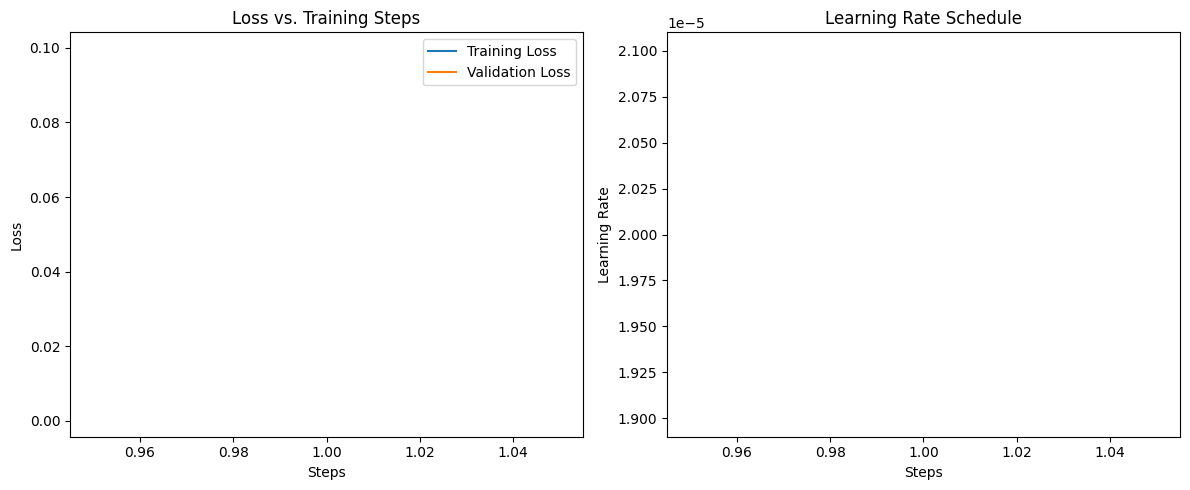

In [51]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
eval_loss = []
learning_rates = []
steps = []

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
        steps.append(entry["step"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "learning_rate" in entry:
        learning_rates.append(entry["learning_rate"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
if eval_loss:
    # eval_loss is per epoch — fewer points
    plt.plot(
        steps[:len(eval_loss)],  # align epochs to steps if possible
        eval_loss,
        label="Validation Loss"
    )
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs. Training Steps")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps[:len(learning_rates)], learning_rates)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def tag_sentence(text:str):

    # convert our text to a  tokenized sequence
    inputs = tokenizer(text, truncation=True, return_tensors="pt", return_token_type_ids=False).to("cuda:0")

    # get outputs
    outputs = model(**inputs)

    # convert to probabilities with softmax
    probs = outputs[0][0].softmax(1)

    # get the tags with the highest probability
    word_tags = [(tokenizer.decode(inputs['input_ids'][0][i].item()), id2label[tagid.item()]) 
                  for i, tagid in enumerate (probs.argmax(axis=1))]

    return pd.DataFrame(word_tags, columns=['word', 'tag'])

In [ ]:
sample = "O senador de São Paulo decidiu faltar a apelação, movida pelo Supremo Tribunal Federal."

tag_sentence(sample)

# RTE

In [52]:
from datasets import load_dataset

dataset = load_dataset("nilc-nlp/assin2")

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 500
    })
})

In [53]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_name, local_files_only=True, cache_dir=CACHED_DATA_FOLDER
)

def preprocess(example):
    return tokenizer(example["premise"], 
                     example["hypothesis"], 
                     truncation=True, 
                     padding="max_length", 
                     max_length=512)

encoded_dataset = dataset.map(preprocess, batched=True)

encoded_dataset = encoded_dataset.rename_column("entailment_judgment", "labels")

encoded_dataset = encoded_dataset.remove_columns(["sentence_pair_id", "relatedness_score"])

encoded_dataset.set_format(type="pt", columns=["input_ids", "attention_mask", "labels"])

encoded_dataset

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [54]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [55]:
from transformers import ModernBertForSequenceClassification

model = ModernBertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=last_checkpoint_path,
    num_labels=2,
)

model

Flash Attention 2 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in ModernBertForSequenceClassification is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", dtype=torch.float16)`
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at /work1/lgarcia/renneruan/training_test/Modern/classiccc-1024-unigram-32768-900ksteps/checkpoint-900000 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(32768, 768, padding_idx=0)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=10000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_f

In [56]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)  # Convert logits to class predictions

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    
    return {"accuracy": acc, "macro_f1": f1}


In [57]:
from transformers import TrainingArguments, Trainer
from transformers import get_wsd_schedule
from torch.optim import AdamW

total_steps = 10_000

training_args = TrainingArguments(
    output_dir=f"./training/RTE/{model_name}",

    max_steps=total_steps,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,

    save_strategy="steps",
    save_steps=100,
    save_total_limit=10,

    eval_strategy="steps",  
    eval_steps=100,

    logging_strategy="steps",
    logging_first_step=True, 
    logging_steps=100,

    logging_dir=f"./rte-logs/{model_name}",
    report_to=["tensorboard"],

    learning_rate=1e-5,
    weight_decay=1e-4,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",  # computed by compute metrics()
    greater_is_better=True, # Greater is better for f1
    # fp16=True,
)

optimizer = AdamW(
    model.parameters(), 
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay,
)

# lr_scheduler = get_wsd_schedule(
#     optimizer=optimizer,
#     num_warmup_steps= training_args.max_steps * 0.1,
#     num_stable_steps= training_args.max_steps * 0.3,
#     num_decay_steps= training_args.max_steps * 0.6,
#     min_lr_ratio= 0,
#     num_cycles= 0.5,
# )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    # optimizers=(optimizer, lr_scheduler),
)

In [58]:
import torch 
torch.cuda.empty_cache()

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1
100,0.934500,0.444479,0.800000,0.799971
200,0.556500,0.554863,0.760000,0.750814
300,0.631600,0.449172,0.810000,0.809597
400,0.489100,1.070379,0.778000,0.771069
500,0.656500,0.599448,0.810000,0.805135
600,0.520100,0.398451,0.866000,0.865548
700,0.379100,0.546256,0.870000,0.868288
800,0.544200,0.419676,0.878000,0.877399
900,0.461900,0.501318,0.874000,0.872778
1000,0.619100,0.351634,0.904000,0.903653


TrainOutput(global_step=10000, training_loss=0.18288875359892845, metrics={'train_runtime': 1042.8739, 'train_samples_per_second': 38.356, 'train_steps_per_second': 9.589, 'total_flos': 1.363031384064e+16, 'train_loss': 0.18288875359892845, 'epoch': 6.153846153846154})

In [59]:
results = trainer.evaluate(encoded_dataset["test"])

print(results)

{'eval_loss': 1.0337486267089844, 'eval_accuracy': 0.8611111111111112, 'eval_macro_f1': 0.8599594173051879, 'eval_runtime': 13.7542, 'eval_samples_per_second': 177.982, 'eval_steps_per_second': 44.495, 'epoch': 6.153846153846154}


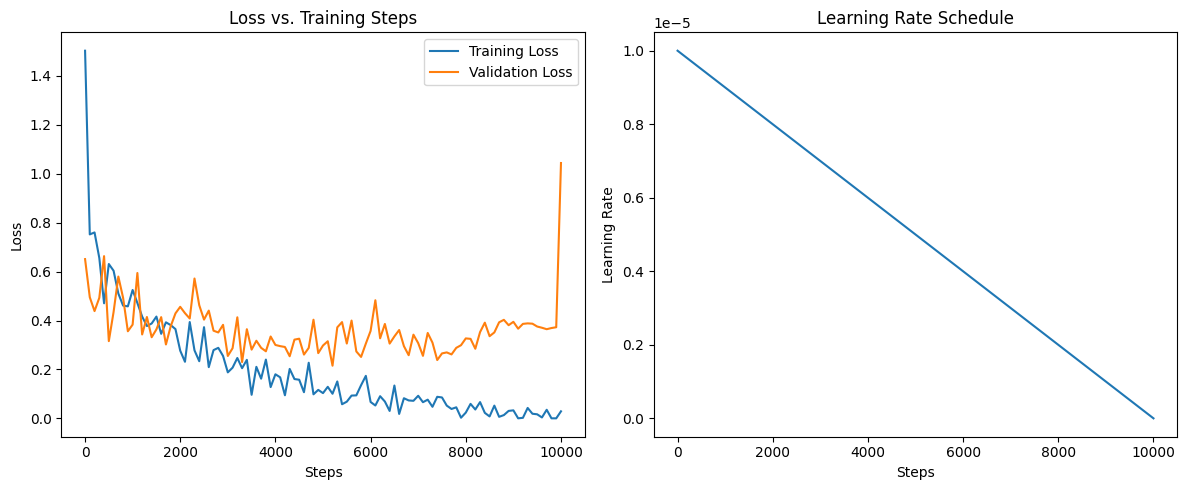

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
eval_loss = []
learning_rates = []
steps = []

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
        steps.append(entry["step"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "learning_rate" in entry:
        learning_rates.append(entry["learning_rate"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
if eval_loss:
    # eval_loss is per epoch — fewer points
    plt.plot(
        steps[:len(eval_loss)],  # align epochs to steps if possible
        eval_loss,
        label="Validation Loss"
    )
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs. Training Steps")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps[:len(learning_rates)], learning_rates)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import DataLoader
import torch

loader = DataLoader(encoded_dataset["test"], batch_size=8)

model.eval()
examples = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        for inp_ids, pred, label in zip(input_ids, predictions, labels):
            text_pair = tokenizer.decode(inp_ids, skip_special_tokens=False)
            examples.append((text_pair, pred.item(), label.item()))

        if len(examples) >= 5:
            break

# Pretty print examples
for i, (text_pair, pred, label) in enumerate(examples[:5]):
    print(f"Example {i+1}")
    print(f"📝 Sentence Pair: {text_pair}")
    print(f"📊 Predicted Label: {pred} ({'Entailment' if pred==1 else 'Not Entailment'})")
    print(f"✅ Ground Truth: {label} ({'Entailment' if label==1 else 'Not Entailment'})")
    print("-" * 50)


Example 1
📝 Sentence Pair: [CLS] o cachorro caramelo está assistindo um cachorro castanho que está nadando em uma lagoa[SEP] um cachorro de estimação está de pé no banco e está olhando outro cachorro , que é castanho , na lagoa[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

# STS

In [32]:
from datasets import load_dataset

dataset = load_dataset("nilc-nlp/assin2")

dataset

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


README.md: 0.00B [00:00, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 500
    })
})

In [33]:
from transformers import AutoTokenizer

def preprocess(example):
    return tokenizer(example["premise"], 
                     example["hypothesis"], 
                     truncation=True, 
                     padding="max_length", 
                     max_length=512)

encoded_dataset = dataset.map(preprocess, batched=True)

encoded_dataset = encoded_dataset.rename_column("relatedness_score", "labels")

encoded_dataset = encoded_dataset.remove_columns(["sentence_pair_id", "entailment_judgment"])

encoded_dataset.set_format(type="pt", columns=["input_ids", "attention_mask", "labels"])

encoded_dataset

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [63]:
from transformers import ModernBertForSequenceClassification

model = ModernBertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=last_checkpoint_path, num_labels=1)

model

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at /work1/lgarcia/renneruan/training_test/Modern/4.6/checkpoint-500000 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(32768, 768, padding_idx=0)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_

In [64]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = predictions.squeeze() 
    labels = labels.squeeze() 
    
    mse = mean_squared_error(labels, predictions)
    pearson_corr, _ = pearsonr(labels, predictions)

    return {"mse": mse, "pearson": pearson_corr}


In [65]:
from transformers import TrainingArguments, Trainer
from transformers import get_wsd_schedule, get_cosine_schedule_with_warmup
from torch.optim import AdamW

total_steps = 5_000

training_args = TrainingArguments(
    output_dir=f"./training/STS/{model_name}",

    max_steps=total_steps,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,

    save_strategy="steps",
    save_steps=100,
    save_total_limit=20,

    eval_strategy="steps",  
    eval_steps=100,

    logging_strategy="steps",
    logging_first_step=True, 
    logging_steps=100,

    # logging_dir=f"./sts-logs/{model_name}",
    # report_to=["tensorboard"],

    learning_rate=2e-5,
    weight_decay=1e-4,

    load_best_model_at_end=True,
    metric_for_best_model="mse",  # computed by compute metrics()
    greater_is_better=False, # lower is better for mse

    # fp16=True,
)

optimizer = AdamW(
    model.parameters(), 
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay,
)

lr_scheduler = get_wsd_schedule(
    optimizer=optimizer,
    num_warmup_steps= training_args.max_steps * 0.1,
    num_stable_steps= training_args.max_steps * 0.2,
    num_decay_steps= training_args.max_steps * 0.7,
    min_lr_ratio= 0,
    num_cycles= 0.5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
)

In [66]:
torch.cuda.empty_cache()

trainer.train()

/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Mse,Pearson
100,2.363600,0.837261,0.837261,0.486903
200,0.933300,0.888699,0.888699,0.635520
300,0.861600,1.721452,1.721452,0.662898
400,0.705400,0.624941,0.624941,0.705630
500,0.648900,0.533049,0.533049,0.741981
600,0.753700,0.843452,0.843452,0.657855
700,0.720600,0.429749,0.429749,0.763144
800,0.514100,0.446056,0.446056,0.744340
900,0.467600,0.455737,0.455737,0.750534
1000,0.419200,0.540454,0.540454,0.747133


/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/work1/l

TrainOutput(global_step=5000, training_loss=0.3303077522277832, metrics={'train_runtime': 762.7991, 'train_samples_per_second': 104.877, 'train_steps_per_second': 6.555, 'total_flos': 2.721136990219469e+16, 'train_loss': 0.3303077522277832, 'epoch': 12.285012285012286})

In [67]:
results = trainer.evaluate(encoded_dataset["test"])

print(results)

/work1/lgarcia/renneruan/amd_200/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.48398664593696594, 'eval_mse': 0.48398664593696594, 'eval_pearson': 0.8081270680900716, 'eval_runtime': 23.395, 'eval_samples_per_second': 104.638, 'eval_steps_per_second': 6.54, 'epoch': 12.285012285012286}


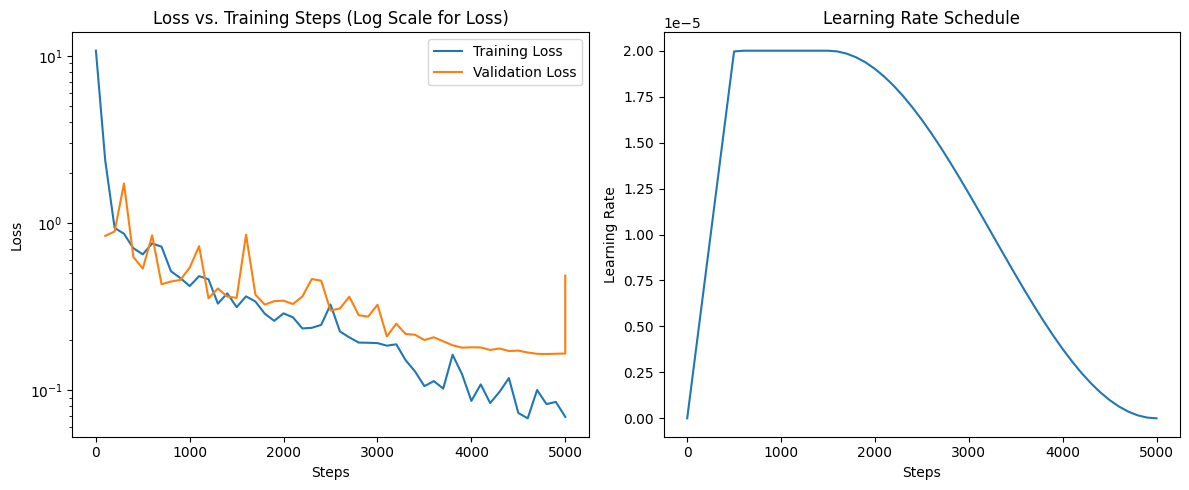

In [68]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
train_steps = []

eval_loss = []
eval_steps = []

learning_rates = []
lr_steps = []

for entry in logs:
    if "loss" in entry and "step" in entry:
        train_loss.append(entry["loss"])
        train_steps.append(entry["step"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
        eval_steps.append(entry["step"])
    if "learning_rate" in entry:
        learning_rates.append(entry["learning_rate"])
        lr_steps.append(entry["step"])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Training and Evaluation Loss (log scale)
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label="Training Loss")
if eval_loss:
    plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.yscale("log")  # Only here
plt.title("Loss vs. Training Steps (Log Scale for Loss)")
plt.legend()

# Plot Learning Rate (linear scale)
plt.subplot(1, 2, 2)
plt.plot(lr_steps, learning_rates)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.tight_layout()
plt.show()


In [69]:
from torch.utils.data import DataLoader
import torch

loader = DataLoader(encoded_dataset["test"], batch_size=8)

model.eval()

examples = []
with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze()

        # Rescale predictions and labels from [0,1] → [0,5]
        preds_rescaled = preds
        labels_rescaled = labels

        for p, l, id_ in zip(preds_rescaled, labels_rescaled, input_ids):
            text_pair = tokenizer.decode(id_, skip_special_tokens=False)
            examples.append((text_pair, p.item(), l.item()))

        if len(examples) >= 5:
            break

for i, (text_pair, pred, label) in enumerate(examples[:5]):
    print(f"Example {i+1}")
    print(f"📝 Sentence Pair: {text_pair}")
    print(f"📊 Predicted Similarity: {pred:.4f}")
    print(f"✅ Ground Truth: {label:.4f}")
    print("-" * 50)


Example 1
📝 Sentence Pair: [CLS] o cachorro caramelo está assistindo um cachorro castanho que está nadando em uma lagoa[SEP] um cachorro de estimação está de pé no banco e está olhando outro cachorro , que é castanho , na lagoa[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA